# Final Python Project
### Ray Chandonnet
### 12/16/2022

Key Assumptions and modeling approaches:

Assumptions:
- All salaries in the Salary file are already in USD and so no 
  FX conversion was done (this wasn't totally clear but seemed
  the case)
- Only used salary for jobs titled as Data Scientist
- Assigned experience levels as follows:
   ~ 0-5 years experience = "Junior"
   ~  >5 years experience = ""Senior"
- Used all salaries for all dates, meaning I assume the data is pretty
  evenly distributed across years for all cities (Otherwise data
  is actually not granular enough to be meaningful)
- I only use CASH compensation to calculate affordability, since
  you can't pay bills with stock grants, which are intended to
  build wealth and usually are on a vesting schedule

Modeling approaches:

- I consider the most important index to be "Cost of Living Plus Rent"
  which factors in housing costs which are a critical component of
  cost of living
- The cost of living indexes provided use NYC as the baseline 
  index of 100, so all other indexes are expressed relative to NYC
- Given that, I construct a comparable "salary index" for all cities in 
  the salary file, also relative to NYC.  So NYC is 100; if a job pays 
  only 75% less than the average comparable job in NYC it gets a salary
  index of 75;  If it pays 1.2x a comparable job in NYC it gets a salary
  index of 120
- These indexes are done using separate average salaries for the two 
  experience levels I created, to avoid skewing results where more junior
  or senior people exist in a given city, making salaries seem higher or
  lower than they really area
- I then create an "affordability index" which is salary index divided by
  cost of living index.  Since both indices are relative to NYC, NYC is 
  deemed to have an affordability index of 100, with more affordable 
  cities than NYC having an index higher than 100 and less affordable 
  cities than NYC having an index the result
- The idea is that how affordable a city is a function of how much you
  earn relative to the cost of living there. If an area costs a lot less
  to live than NYC, but pays almost as much, it's more affordable.  The
  converse is also true.  
- I then rank order the cities by affordability, for both junior and senior
  people.
- I also ran a few plots to see if there was a difference (skew) in overall
  affordability for junior vs senior people, and also ran 


In [27]:
# import needed libraries and set file path prefix
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
path = "/users/raychandonnet/Dropbox (Personal)/Merrimack College - \
MS in Data Science/DSE5002/Python Project/"

# Part 1:  Data Wrangling the Cost of Living Index File

In [28]:
cost_of_living=pd.read_csv(path + "cost_of_living.csv")
cost_of_living=cost_of_living.rename(columns=\
  {"Cost of Living Plus Rent Index":"RealCOL_Index"})
# Step 1 - Break the City up - requires a lot of cleaning because city and 
# country are in the same field separated by
# a comma, and US cities also have the state in form city, st, country.  
# I want to break these up into separate columns to link to the country
# code data, then pull in job info for those city / country combos
# First, split the city into three separate fields
cost_of_living[['City','State','Country']]=cost_of_living['City'].str.\
    split(pat=",",n=2,expand=True)
# This leaves the city state and country correct for US cities, but has the 
# country in the city column for non-US cities and "None" for country, so we 
# have to fix that  It's two steps:
# First, repalce all the "None" in Country column with the State value which 
# is where the Country is. Then eliminate the dups by putting "-" in the State
# field for all those.  So we basically just swapped values to get the country
# in the right place
cost_of_living['Country']=cost_of_living['Country'].\
    fillna(cost_of_living['State']) # Puts the state value in country where NA
cost_of_living['State']=np.where(cost_of_living['State']\
                                 ==cost_of_living['Country'],
                                 "-",cost_of_living['State'])
# It took me more time than I care to admit to realize that my states and 
# countries had padded whitespace and so weren't matching when I tried to 
# merge in the country code data!!! Sigh....using the strip method fixes that
cost_of_living['Country']=cost_of_living['Country'].str.strip()
cost_of_living['State']=cost_of_living['State'].str.strip()
# This leaves us with City, State and Country, with country spelled out
# Now I can merge in the country codes from that file into my table.  This 
# will let me connect to data in the salary and jobs files once I do some 
# stuff with that data, if I need to use a code instead of the country
# spelled out
countrycodes=pd.read_excel(path+"country_codes.xlsx")
cost_of_living=pd.merge(left=cost_of_living,right=countrycodes,
                        how='left',on='Country')
print(cost_of_living.head(10))

   Rank       City  Cost of Living Index  Rent Index  RealCOL_Index  \
0   NaN   Hamilton                149.02       96.10         124.22   
1   NaN     Zurich                131.24       69.26         102.19   
2   NaN      Basel                130.93       49.38          92.70   
3   NaN        Zug                128.13       72.12         101.87   
4   NaN     Lugano                123.99       44.99          86.96   
5   NaN   Lausanne                122.03       59.55          92.74   
6   NaN     Beirut                120.47       27.76          77.01   
7   NaN       Bern                118.16       46.12          84.39   
8   NaN     Geneva                114.05       75.05          95.77   
9   NaN  Stavanger                104.61       35.38          72.16   

   Groceries Index  Restaurant Price Index  Local Purchasing Power Index  \
0           157.89                  155.22                         79.43   
1           136.14                  132.52                        

# Part 2 - Data wrangling the salary data

I chose to use this data as the source for my income in calculating salary
indexes relative to NY, a necessary pre-requisite to calculating an
affordability index. There so many different ways we could slice and dice
the data - I will be focusing on cash compensation and seniority,
specifically for the salaries listed there as Data Scientist

In [29]:
# Read in the salaries file and do some data wrangling here as well to
# convert the time stamp to a date, and put the cities and countries in the
# right columns
#
# I did not end up using the date column in any way - ran out of time
# But wanted to show I knew how to convert it
salaries=pd.read_csv(path+"Levels_Fyi_Salary_Data.csv") # read data
salaries=salaries[salaries['title']=="Data Scientist"] # Slice the DS jobs
salaries['timestamp'] = pd.to_datetime(salaries['timestamp']) # convert date
salaries=salaries.rename({"timestamp":"date"},axis=1) #rename date column
salaries[['City','State','Country']]=salaries['location'].\
    str.split(pat=",",n=2,expand=True)
# Now fill in "United States" where country is blank, delete the state for 
# non-US locations, and remove whitespace
salaries['Country']=salaries['Country'].fillna("United States") 
salaries['State']=np.where(salaries['Country']!='United States',
                           "-",salaries['State']) # delete states for non-US
salaries['Country']=salaries['Country'].str.strip()
salaries['State']=salaries['State'].str.strip()
print(salaries.head(10))

                   date    company            level           title  \
419 2018-06-05 14:06:30   LinkedIn           Senior  Data Scientist   
440 2018-06-08 09:49:25  Microsoft               64  Data Scientist   
444 2018-06-08 17:55:09       ebay               26  Data Scientist   
454 2018-06-10 19:39:35    Twitter            Staff  Data Scientist   
495 2018-06-17 11:39:38   Facebook                5  Data Scientist   
499 2018-06-17 19:02:50     Amazon               L5  Data Scientist   
509 2018-06-20 00:47:43  Microsoft               65  Data Scientist   
510 2018-06-20 00:49:11     Google               L6  Data Scientist   
513 2018-06-21 10:54:35    Netflix           Senior  Data Scientist   
523 2018-06-25 08:45:29      Tesla  Senior Engineer  Data Scientist   

     totalyearlycompensation           location  yearsofexperience  \
419                   233000  San Francisco, CA                4.0   
440                   218000        Seattle, WA               11.0   
444     

# Part 3:  Enriching the salary data

 Now I'm going to enrich the data a bit to make it more granular and make more 
 sense: First, I calculate "cashcomp" as cash compensation = base + bonus.Then
 I tag each salary with a "Junior" or "Senior" experience level as noted above

In [30]:
salaries['cashcomp']=salaries['basesalary']+salaries['bonus'] 
salaries=salaries[salaries['cashcomp']!=0]  # eliminate zeros 
salaries['explevel']=np.where(salaries['yearsofexperience']<=5,
                              "Junior","Senior")
print(salaries.head(10))

                   date    company            level           title  \
419 2018-06-05 14:06:30   LinkedIn           Senior  Data Scientist   
440 2018-06-08 09:49:25  Microsoft               64  Data Scientist   
454 2018-06-10 19:39:35    Twitter            Staff  Data Scientist   
495 2018-06-17 11:39:38   Facebook                5  Data Scientist   
499 2018-06-17 19:02:50     Amazon               L5  Data Scientist   
509 2018-06-20 00:47:43  Microsoft               65  Data Scientist   
510 2018-06-20 00:49:11     Google               L6  Data Scientist   
513 2018-06-21 10:54:35    Netflix           Senior  Data Scientist   
523 2018-06-25 08:45:29      Tesla  Senior Engineer  Data Scientist   
535 2018-06-26 21:37:46    GrubHub               II  Data Scientist   

     totalyearlycompensation           location  yearsofexperience  \
419                   233000  San Francisco, CA                4.0   
440                   218000        Seattle, WA               11.0   
454     

# Part 4 - Aggregating by city/level, isolating NYC

Now I aggregate by city, state, country and experience level, 
calculating mean salary for each subset.   Then, since in the cost of living
data, the indexes re calculated using NYC as baseline (100 index), 
I calculate a "salary index" for each city and experience 
combination, relative to that same experience level in NYC so everything is
on a common denominator

In [31]:
sal_by_city=salaries.groupby(['Country','City','State','explevel'],
                             as_index=False).agg(avg_salary=('cashcomp', 
                                                             np.mean)) 
NYCsal=salaries[salaries['City']=="New York"] # Extract all the NYC jobs
NYC_by_level=NYCsal.groupby('explevel').agg(
    NYC_avg_salary=('cashcomp', np.mean))  # Calc NYC mean salaries by level
print(sal_by_ctry.head(5))
print(sal_by_city.head(5))
print(NYC_by_level.head())

     Country explevel     avg_salary
0  Australia   Junior   89333.333333
1  Australia   Senior  213500.000000
2    Austria   Junior   17000.000000
3     Brazil   Senior   28000.000000
4     Canada   Junior   95297.297297
     Country       City State explevel  avg_salary
0  Australia   Canberra     -   Junior     93000.0
1  Australia  Melbourne     -   Junior     67000.0
2  Australia  Melbourne     -   Senior    142000.0
3  Australia     Sydney     -   Junior    108000.0
4  Australia     Sydney     -   Senior    285000.0
          NYC_avg_salary
explevel                
Junior     156672.131148
Senior     230960.784314


# Part 5 - Calculate salary and affordability indexes

Here comes the magic!  Now that I have average salaries for NYC by level, 
I can use those to create a salary index, with NYC as the baseline at 100, 
for each city/level combo I found. Once that cost of living index 
is calculated, I can derive an "affordability" index dividing the salary 
index for that city/country/level into the cost  of living index for that 
city/country. So for example if the salary index is 80 (80% of NYC) but 
the cost of living index is 40 (50% of NYC), then that location for that 
experience level is twice as affordable as NYC (80/40=2x) or 
affordability = 200 meaning your money goes twice as far

In [32]:
afford_city_level=pd.merge(left=sal_by_city,right=NYC_by_level,
                           how='left',on='explevel') #Pull in NYC salary/level
afford_city_level['sal_index']=afford_city_level['avg_salary']\
    /afford_city_level['NYC_avg_salary']*100 # Calculate salary index
afford_city_level=pd.merge(left=afford_city_level,
                           right=cost_of_living,
                           how='left',
                           on=['City','State','Country']) 
afford_city_level['affordability']=afford_city_level['sal_index']\
    /afford_city_level['RealCOL_Index']*100
print(afford_city_level.head())

     Country       City State explevel  avg_salary  NYC_avg_salary  \
0  Australia   Canberra     -   Junior     93000.0   156672.131148   
1  Australia  Melbourne     -   Junior     67000.0   156672.131148   
2  Australia  Melbourne     -   Senior    142000.0   230960.784314   
3  Australia     Sydney     -   Junior    108000.0   156672.131148   
4  Australia     Sydney     -   Senior    285000.0   230960.784314   

    sal_index  Rank  Cost of Living Index  Rent Index  RealCOL_Index  \
0   59.359632   NaN                 75.94       42.50          60.26   
1   42.764466   NaN                 76.76       38.65          58.90   
2   61.482299   NaN                 76.76       38.65          58.90   
3   68.933766   NaN                 83.21       58.03          71.41   
4  123.397572   NaN                 83.21       58.03          71.41   

   Groceries Index  Restaurant Price Index  Local Purchasing Power Index  \
0            76.81                   79.07                        105.

# Part 6 - Slice and analyze the results

I want to rank order affordability individually for junior and senior
people, as well as overall.  For overall, I will average the affordability
index for junior and senior people.  But I think it's more interesting to 
look at junior and senior people separately to see if there are big
differences

In [33]:
# First delete all the NaN's, which represent cities for which we have no
# cost of living index and thus no affordability calculation
afford_city_level=afford_city_level[afford_city_level['affordability'].notna()]
# Now slice the data into Junior vs Senior people, and also average the
# affordability for each city/state/country
afford_city_junior=afford_city_level[afford_city_level['explevel']=="Junior"]
afford_city_junior=afford_city_junior[['Country','City','State',
                                       'RealCOL_Index','sal_index',
                                       'affordability']] # slice columns needed
afford_city_senior=afford_city_level[afford_city_level['explevel']=="Senior"]
afford_city_senior=afford_city_senior[['Country','City','State',
                                       'RealCOL_Index','sal_index',
                                       'affordability']] # slice columns needed
# Now group everything, averaging out the indexes for junior and senior people
afford_city_both=afford_city_level.groupby(['Country','City','State'],\
    as_index=False).agg(
                        RealCOL_Index=('RealCOL_Index',np.mean),
                        sal_index=('sal_index',np.mean),
                        affordability=('affordability',np.mean))
# Sort all 3 tables descending by affordability
afford_city_junior=afford_city_junior.sort_values(by=['affordability'],
                                                ascending=False)
afford_city_junior=afford_city_junior.sort_values(by=['affordability'],
                                                ascending=False)
afford_city_senior=afford_city_senior.sort_values(by=['affordability'],
                                                ascending=False)
afford_city_both=afford_city_both.sort_values(by=['affordability'],
                                                ascending=False)
print("Top five most affordable cities for JUNIOR data scientists:")
print(afford_city_junior.head(5))
print("Top five most affordable cities for SENIOR data scientists:")
print(afford_city_senior.head(5))
print("Top five most affordable cities for data scientists regardless of \
level:")
print(afford_city_both.head(5))

Top five most affordable cities for JUNIOR data scientists:
                  Country        City State  RealCOL_Index   sal_index  \
79   United Arab Emirates       Dubai     -          54.83   93.826515   
109         United States    Berkeley    CA          91.48  155.100973   
233         United States     Oakland    CA          90.52  151.909595   
244         United States  Pittsburgh    PA          62.10  104.038924   
87          United States   Ann Arbor    MI          59.82  100.209271   

     affordability  
79      171.122587  
109     169.546320  
233     167.818819  
244     167.534500  
87      167.518005  
Top five most affordable cities for SENIOR data scientists:
           Country         City State  RealCOL_Index   sal_index  \
271  United States  San Antonio    TX          51.19  173.189575   
43           India       Mumbai     -          24.82   57.152560   
198  United States  Los Angeles    CA          76.98  170.358591   
33           India    Bangalore     -

# Part 7 - Comparing junior to senior affordability

If we plot the kernel density of affordability indexes to see if there are
insights, an interesting insight comes out of it:   Both affordability
plots seem pretty normally distributed.  But given that 100 is the index
base for NYC, we see the following:

- For Senior people, New York is right in the middle of the distribution
  meaning there are as many cities less affordable than NYC than more
- However, for Junior people, the median of the distribution is
  shifted to the left meaning there are more cities that are more affordable
  than NYC than there are those less affordable.  Seems NYC hero worship
  of experience, and making lower level people suffer, are alive and well!

One other thing of note is that the distribution of affordability for Senior
people has a long "tail" to the right, suggesting that there are outliers 
in the data where Senior people were well overpaid to be lured to a low
cost of living city.  Digging into the data, this seems to be why San Antonio
found its way into the top 5 for Senior people

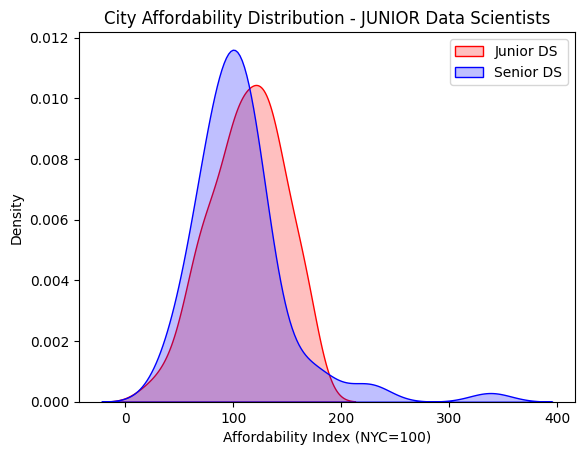

In [34]:
junior_scores=afford_city_junior['affordability']
junior_scores=junior_scores.rename("Junior") # rename
senior_scores=afford_city_senior['affordability']
junior_scores=junior_scores.rename("Senior") # rename
fig = sns.kdeplot(junior_scores, fill=True, color="r") # plot junior scores
fig = sns.kdeplot(senior_scores, fill=True, color="b") # plot senior scores
plt.title('City Affordability Distribution - JUNIOR Data Scientists')
plt.ylabel('Density')
plt.xlabel('Affordability Index (NYC=100)')
plt.legend(labels=["Junior DS","Senior DS"],loc='upper right')
plt.show()

# Part 8 - Identifying factors driving affordability

One other useful graphing analysis looks at what drives affordability
in a given city for data scientists, and if it's different for Junior
versus Senior people. If cost of living and salaries are in synch,
there shouldn't be much to infer.  But what if they are not? I looked
at two possible factors:

1) Affordability is driven by cost-of-living - meaning, cities with 
   lower cost of living (including housing) are more affordable even
   despite paying lower salaries.  
2) Affordability is driven by salaries - meaning, cities with higher 
   salaries are more affordable even when real cost of living is high
   
What the below plots seem to show is :

1) Cost of living isn't a very big driver of affordability of a place.  
   The vast majority of cities are cheaper than NYC, but as many of them
   are less affordable (affordability index <100) as more affordable, and
   it doesn't seem to matter how cheap a place is to live.  
   The flat trendline on the first graph shows this
2) On the other hand, the second plot seems to suggest that local salaries 
   are a significant driver of affordability.  The more money you make, 
   both at a junior and senior level, the more a specific city is affordable
   no mater what the local cost of living is
   
It could be that some of my assumptions (especially assuming offshore 
salaries are in USD in that file) are faulty.  It could also be that the 
data sample size is too small.  But hopefully I've demonstrated the power
of data analytics!

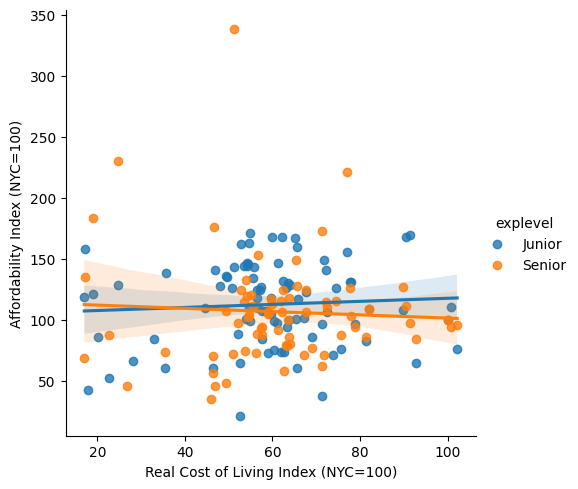

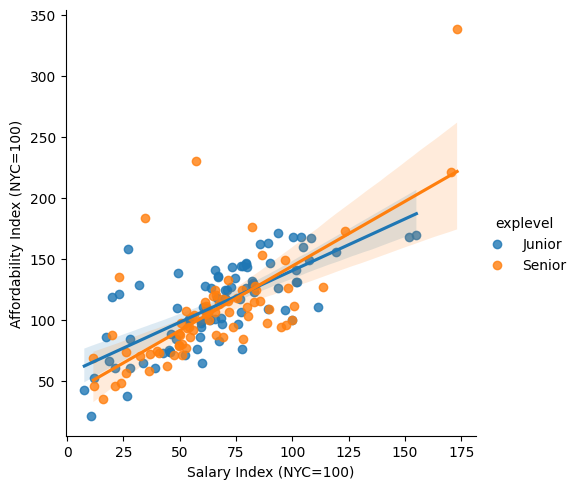

In [35]:
# Now show regression of affordability vs cost of living to see if strong
# relationshp
data_to_plot=afford_city_level[['explevel','RealCOL_Index','affordability']]
sns.lmplot(x = 'RealCOL_Index',
            y = 'affordability',
            hue = 'explevel',
            data=data_to_plot)
plt.ylabel('Affordability Index (NYC=100)')
plt.xlabel('Real Cost of Living Index (NYC=100)')
plt.show()
# Finally, show regression of affordability vs salaries to see if strong
# relationshp
data_to_plot=afford_city_level[['explevel','sal_index','affordability']]
sns.lmplot(x = 'sal_index',
            y = 'affordability',
            hue = 'explevel',
            data=data_to_plot)
plt.ylabel('Affordability Index (NYC=100)')
plt.xlabel('Salary Index (NYC=100)')
plt.show()

# Thank you for listening to my TED Talk

I enjoyed this class a ton!   I can't believe how much I learned in two languages I had never seen (and one, "R", that I'd never even heard of.